In [16]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from nltk.tokenize import sent_tokenize 

In [17]:

dataframe = pd.read_csv('essays_and_scores.csv', encoding = 'latin-1')

In [18]:
dataframe.head(5)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


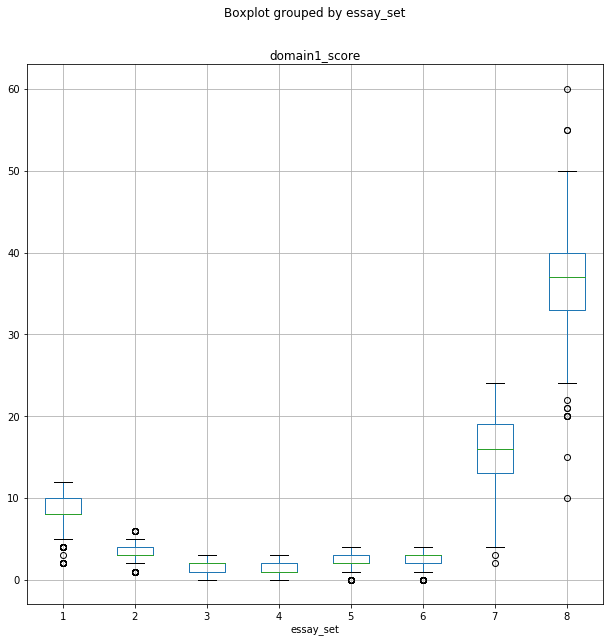

In [19]:
dataframe.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

In [20]:
data = dataframe[['essay_set','essay','domain1_score']].copy()
print(data)

       essay_set                                              essay  \
0              1  Dear local newspaper, I think effects computer...   
1              1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2              1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3              1  Dear Local Newspaper, @CAPS1 I have found that...   
4              1  Dear @LOCATION1, I know having computers has a...   
5              1  Dear @LOCATION1, I think that computers have a...   
6              1  Did you know that more and more people these d...   
7              1  @PERCENT1 of people agree that computers make ...   
8              1  Dear reader, @ORGANIZATION1 has had a dramatic...   
9              1  In the @LOCATION1 we have the technology of a ...   
10             1  Dear @LOCATION1, @CAPS1 people acknowledge the...   
11             1  Dear @CAPS1 @CAPS2 I feel that computers do ta...   
12             1  Dear local newspaper I raed ur argument on the...   
13    

In [21]:
def sentence_to_wordlist(raw_sentence):
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    return tokens

In [22]:
def tokenize(essay):
    stripped_essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    return tokenized_sentences

In [23]:
def avg_word_len(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    return sum(len(word) for word in words) / len(words)

In [24]:
def word_count(essay): 
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    return len(words)

In [25]:
def char_count(essay):
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    return len(clean_essay)

In [26]:
def sent_count(essay):    
    sentences = nltk.sent_tokenize(essay)
    return len(sentences)


In [27]:
def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [28]:
def count_spell_error(essay):
    
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
    
    #big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg 
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()
    
    words_ = re.findall('[a-z]+', data.lower())
    
    word_dict = collections.defaultdict(lambda: 0)
                       
    for word in words_:
        word_dict[word] += 1
                       
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
                        
    mispell_count = 0
    
    words = clean_essay.split()
                        
    for word in words:
        if not word in word_dict:
            mispell_count += 1
    
    return mispell_count

In [29]:
def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            
    return noun_count, adj_count, verb_count, adv_count
    

In [30]:
def get_count_vectors(essays):
    
    vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
    
    count_vectors = vectorizer.fit_transform(essays)
    
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, count_vectors

In [31]:
feature_names_cv, count_vectors = get_count_vectors(data[data['essay_set'] == 1]['essay'])

X_cv = count_vectors.toarray()

y_cv = data[data['essay_set'] == 1]['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

In [32]:
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


Coefficients: 
 [-0.00920777  0.07720086 -0.05096964 ... -0.05739351  0.02313521
  0.01218706]
Mean squared error: 1.88
Variance score: 0.09
Cohen's kappa score: 0.15


In [33]:
# Training a Lasso Regression model (l1 regularization) using only Bag of Words (BOW)

alphas = np.array([3, 1, 0.3, 0.1, 0.03, 0.01])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

C:\Users\KARAN SIKARWAR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.5447022082282523
0.01
Mean squared error: 1.07
Variance score: 0.48
Cohen's kappa score: 0.22


In [34]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['avg_word_len'] = features['essay'].apply(avg_word_len)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
    
    features['spell_err_count'] = features['essay'].apply(count_spell_error)
    
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(*features['essay'].map(count_pos))
    
    return features

In [35]:
# extracting features from essay set 1

features_set1 = extract_features(data[data['essay_set'] == 1])

print(features_set1)

      essay_set                                              essay  \
0             1  Dear local newspaper, I think effects computer...   
1             1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             1  Dear Local Newspaper, @CAPS1 I have found that...   
4             1  Dear @LOCATION1, I know having computers has a...   
5             1  Dear @LOCATION1, I think that computers have a...   
6             1  Did you know that more and more people these d...   
7             1  @PERCENT1 of people agree that computers make ...   
8             1  Dear reader, @ORGANIZATION1 has had a dramatic...   
9             1  In the @LOCATION1 we have the technology of a ...   
10            1  Dear @LOCATION1, @CAPS1 people acknowledge the...   
11            1  Dear @CAPS1 @CAPS2 I feel that computers do ta...   
12            1  Dear local newspaper I raed ur argument on the...   
13            1  My 

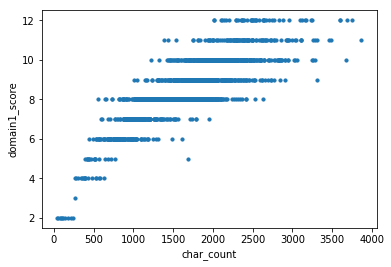

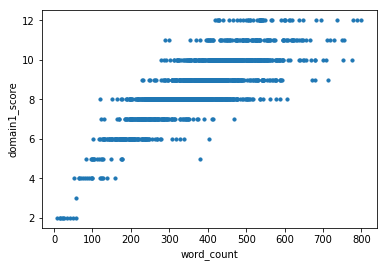

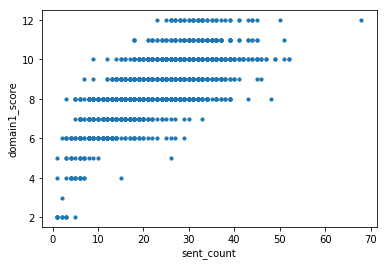

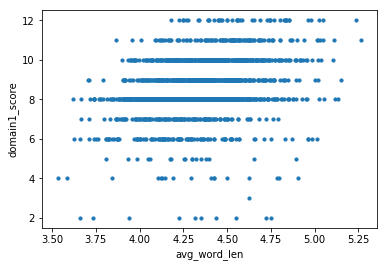

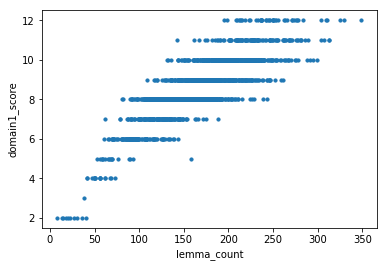

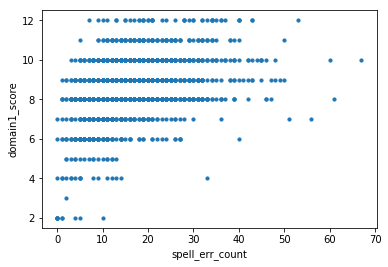

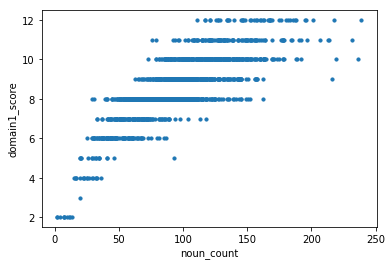

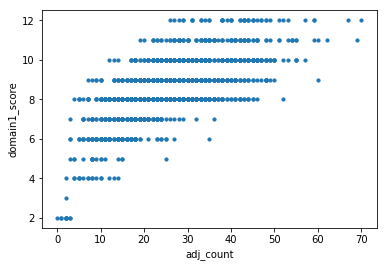

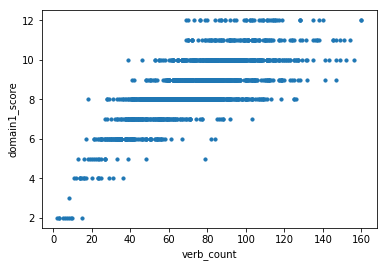

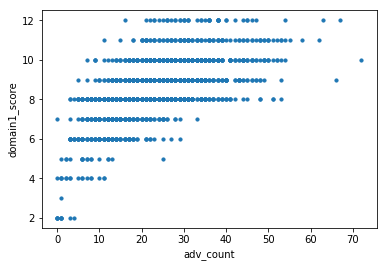

In [36]:
# Exploratory Data Analysis (EDA) on the data

%matplotlib inline
features_set1.plot.scatter(x = 'char_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'word_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'sent_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'avg_word_len', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'lemma_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'spell_err_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'noun_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adj_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'verb_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adv_count', y = 'domain1_score', s=10)

# Essay Set 1 Trends:

# By plotting the below scatter plots, we can examine how different features above affect the grade the student receives.

# 1. I observed that there is a strong correlation between character count of an essay and the final essay score. 
#    I observed similar correlations for word count, sentence count and lemma count of an essay.
#    These features indicate language fluency and dexterity.
# 2. Various parts-of-speech such as nouns, adjectives adverbs and verbs are good proxies to test vocabulary. 
#    This feature can also be taken as a rudimentary proxy for diction.
#    I observed a strong correlation between noun_count and the final essay score. Sililar trends were observed for verb count,
#    adjective count and adverb count of an essay.
# 3. I did not observe any significant correlation between average word length of an essay and its score.
# 4. There is a weaker correlation between the number of spelling errors and the final score of an essay.

In [37]:
# splitting data (BOW + other features) into train data and test data (70/30)
    
X = np.concatenate((features_set1.iloc[:, 3:].as_matrix(), X_cv), axis = 1)

y = features_set1['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [38]:
# Training a Linear Regression model using all the features (BOW + other features)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Coefficients: 
 [ 3.42992878e-05  4.48679780e-03 -1.36534335e-02 ... -6.28931315e-02
  1.12012451e-02  4.90043491e-03]
Mean squared error: 1.28
Variance score: 0.47
Cohen's kappa score: 0.24


C:\Users\KARAN SIKARWAR\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\KARAN SIKARWAR\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\KARAN SIKARWAR\Anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:212: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\KARAN SIKARWAR\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:552: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\KARAN SIKARWAR\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dt

0.7406318028484977
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
MSE: 0.6318
Variance score: 0.74
Cohen's kappa score: 0.39


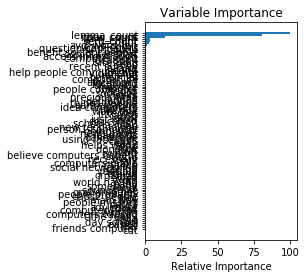

In [39]:
# Training a Gradient Boosting Regression model using all the features (BOW + other features)

params = {'n_estimators':[100, 1000], 'max_depth':[2], 'min_samples_split': [2],
          'learning_rate':[3, 1, 0.1, 0.3], 'loss': ['ls']}

gbr = ensemble.GradientBoostingRegressor()

grid = GridSearchCV(gbr, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

# Plot feature importance - to find the main factors affecting the final grade
feature_importance = grid.best_estimator_.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_names = list(features_set1.iloc[:, 3:].columns.values)
feature_names = np.asarray(feature_names + feature_names_cv)
sorted_idx = np.argsort(feature_importance)
# get top 100
sorted_idx = sorted_idx[9910:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()